# Tutorial: Infrastructure Flow and Complete Pipeline
#
This notebook demonstrates the complete experimental infrastructure of the SSM Analysis project,
showing how raw data flows through the three main experiments: model evaluation, heatmap
generation, and information flow analysis.
#
## Overview
#
The project uses a sophisticated runner-based infrastructure where:
- **Experiment Runners** execute specific analyses (evaluation, heatmaps, info flow)
- **Result Banks** manage and store experimental outputs
- **Data Requirements** coordinate dependencies between experiments
- **Prompt Filteration** controls which data subsets to analyze
#
### The Three Core Experiments
#
1. **EvaluateModel**: Measures model performance on factual completions
2. **Heatmap**: Shows how different layers affect token predictions
3. **InfoFlow**: Traces information flow from subject to prediction tokens

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plotting imports
from src.analysis.plots.info_flow_confidence import InfoFlowPlotConfig, TMetricType, create_confidence_plot
from src.analysis.prompt_filterations import AllPromptFilteration, Correctness, ModelCorrectPromptFilteration

# Project core imports
from src.core.names import COLS, DatasetName
from src.core.types import (
    MODEL_ARCH_AND_SIZE,
    SPLIT,
    FeatureCategory,
    TCodeVersionName,
    TModelSize,
    TokenType,
    TPromptOriginalIndex,
    TWindowSize,
)

# Data and filteration imports
from src.data_ingestion.data_defs.data_defs import PromptNew, Prompts
from src.data_ingestion.datasets.download_dataset import get_raw_data
from src.experiments.infrastructure.base_prompt_filteration import SelectivePromptFilteration
from src.experiments.infrastructure.base_runner import InputParams, MetadataParams

# Experiment runners
from src.experiments.runners.evaluate_model import EvaluateModelParams, EvaluateModelRunner
from src.experiments.runners.heatmap import HEATMAP_PLOT_FUNCS, HeatmapParams, HeatmapRunner
from src.experiments.runners.info_flow import InfoFlowParams, InfoFlowRunner

# Test baseline imports
from tests.src.experiments.baseline_builder import (
    ORIGINAL_IDS,
    TEST_BASE_PATH,
    TEST_MODEL_CONFIGS,
)


## 1. Raw Data Overview
#
Let's start by examining the Counter-Fact dataset structure and understanding how data flows
through the system.

In [2]:
# Load the Counter-Fact dataset
print("📥 Loading Counter-Fact dataset...")
df = get_raw_data(DatasetName.counter_fact)

print(f"✅ Dataset loaded: {len(df)} examples")
print(f"📋 Columns: {list(df.columns)}")

# Show data structure
print("\n🔍 Sample data points:")
sample_data = df.head(3)[
    [
        COLS.COUNTER_FACT.PROMPT,
        COLS.COUNTER_FACT.SUBJECT,
        COLS.COUNTER_FACT.TARGET_TRUE,
        COLS.COUNTER_FACT.TARGET_FALSE,
        COLS.COUNTER_FACT.RELATION,
    ]
]

for idx, row in sample_data.iterrows():
    print(f"  Example {idx + 1}:")
    print(f"    Prompt: '{row[COLS.COUNTER_FACT.PROMPT]}'")
    print(f"    Subject: '{row[COLS.COUNTER_FACT.SUBJECT]}'")
    print(f"    Correct: '{row[COLS.COUNTER_FACT.TARGET_TRUE]}'")
    print(f"    Incorrect: '{row[COLS.COUNTER_FACT.TARGET_FALSE]}'")
    print(f"    Relation: '{row[COLS.COUNTER_FACT.RELATION]}'")
    print()

# Create a Prompts object - the main data container
# Convert to the project's data format
prompts_dict = {TPromptOriginalIndex(idx): PromptNew(row.to_dict()) for idx, row in df.iterrows()}
prompts = Prompts(prompts_dict)

print(f"📦 Created Prompts object with {prompts.size} examples")
print(f"🔢 Prompt indices: {prompts.original_idx[:5]}... (showing first 5)")


📥 Loading Counter-Fact dataset...
✅ Dataset loaded: 21919 examples
📋 Columns: ['relation', 'relation_prefix', 'relation_suffix', 'prompt', 'relation_id', 'target_false_id', 'target_true_id', 'target_true', 'target_false', 'subject', 'original_idx', 'split']

🔍 Sample data points:
  Example 1:
    Prompt: 'Rogers Place, by'
    Subject: 'Rogers Place'
    Correct: ' Edmonton'
    Incorrect: ' Yahoo'
    Relation: '{}, by'

  Example 2:
    Prompt: 'The official religion of Ibn Ishaq is'
    Subject: ' Ibn Ishaq'
    Correct: ' Islam'
    Incorrect: ' Christianity'
    Relation: 'The official religion of {} is'

  Example 3:
    Prompt: 'Israel Zolli is affiliated with the religion'
    Subject: 'Israel Zolli'
    Correct: ' Judaism'
    Incorrect: ' Buddhism'
    Relation: '{} is affiliated with the religion'

📦 Created Prompts object with 21919 examples
🔢 Prompt indices: [0, 1, 2, 3, 4]... (showing first 5)


### Understanding Prompt Filteration
#
The project uses **Prompt Filteration** to control which subsets of data are analyzed. This is
crucial for managing computational resources and focusing on specific cases.

In [3]:
# Demonstrate different prompt filteration strategies

# 1. All prompts filteration
all_prompts_filter = AllPromptFilteration()
print("🌐 All Prompts Filter:")
print(f"   Type: {type(all_prompts_filter).__name__}")
print("   Description: Includes all available prompts")

# 2. Selective prompts filteration (choose specific examples)
selected_indices = [TPromptOriginalIndex(i) for i in range(5)]  # First 5 examples
selective_filter = SelectivePromptFilteration(prompt_ids=tuple(selected_indices))
print("\n🎯 Selective Prompts Filter:")
print(f"   Type: {type(selective_filter).__name__}")
print(f"   Selected indices: {selected_indices}")
print("   Description: Includes only specific prompt IDs")

# Apply filteration to see the difference
all_filtered = prompts.filter_by_prompt_filteration(all_prompts_filter)
selective_filtered = prompts.filter_by_prompt_filteration(selective_filter)

print("\n📊 Filteration Results:")
print(f"   All prompts: {all_filtered.size} examples")
print(f"   Selective: {selective_filtered.size} examples")

# Show which prompts were selected
print("\n🔍 Selected prompts preview:")
for idx in selective_filtered.original_idx:
    prompt_data = selective_filtered.get_prompt(idx)
    print(f"   {idx}: '{prompt_data.prompt_row[COLS.COUNTER_FACT.PROMPT]}'")


🌐 All Prompts Filter:
   Type: AllPromptFilteration
   Description: Includes all available prompts

🎯 Selective Prompts Filter:
   Type: SelectivePromptFilteration
   Selected indices: [0, 1, 2, 3, 4]
   Description: Includes only specific prompt IDs

📊 Filteration Results:
   All prompts: 21919 examples
   Selective: 5 examples

🔍 Selected prompts preview:
   0: 'Rogers Place, by'
   1: 'The official religion of Ibn Ishaq is'
   2: 'Israel Zolli is affiliated with the religion'
   3: 'Nagoya University, in'
   4: 'Abbey of Echternach is located in'


## 2. Experiment Runner Infrastructure
#
The project uses a **BaseRunner** architecture where each experiment inherits common
functionality. Let's examine the parameter system and create runners for our experiments.

In [4]:
# Configuration - Use test baseline data for demonstration
MODEL_ARCH, MODEL_SIZE_STR = TEST_MODEL_CONFIGS[0]  # (MAMBA1, "130M")
MODEL_SIZE = TModelSize(MODEL_SIZE_STR)
WINDOW_SIZE = TWindowSize(15)  # Test baseline window size
code_version = TCodeVersionName("test_baseline")

# Override paths to use test baseline data
from src.core.consts import PATHS

PATHS.PROJECT_DIR = TEST_BASE_PATH

# Set up experiment parameters
demo_filter = ModelCorrectPromptFilteration(
    dataset_name=DatasetName.counter_fact,
    model_arch_and_size=MODEL_ARCH_AND_SIZE(MODEL_ARCH, MODEL_SIZE),
    correctness=Correctness.correct,
    code_version=code_version,
)

input_params = InputParams(
    dataset_name=DatasetName.counter_fact,
    filteration=demo_filter,
)
metadata_params = MetadataParams(code_version=code_version)

f"🔧 Configuration: {MODEL_ARCH}-{MODEL_SIZE}, Window: {WINDOW_SIZE}, Version: {code_version}"


'🔧 Configuration: mamba1-130M, Window: 15, Version: test_baseline'

## 3. EvaluateModel Runner
#
The **EvaluateModelRunner** measures how well models predict the correct completions for
factual statements. This is the foundation for all other analyses.

In [5]:
# Create EvaluateModel runner parameters
evaluate_params = EvaluateModelParams(
    model_arch=MODEL_ARCH,
    model_size=MODEL_SIZE,
    drop_subject=False,  # Keep subject tokens
    drop_subj_last_token=False,  # Keep all subject tokens
    with_3_dots=False,  # No ellipsis in prompts
    new_max_tokens=5,  # Generate up to 5 tokens
    top_k_tokens=10,  # Track top 10 predictions
)

# Create the runner
evaluate_runner = EvaluateModelRunner(
    variant_params=evaluate_params, input_params=input_params, metadata_params=metadata_params
)

f"🏃 Created EvaluateModelRunner: {evaluate_params.model_arch}-{evaluate_params.model_size}"

# Display evaluation results if available
if evaluate_runner.is_computed():
    eval_outputs = evaluate_runner.get_outputs()
    f"✅ Evaluation complete: {len(eval_outputs)} prompts analyzed"
    eval_outputs.head()  # Display first few rows in Jupyter
else:
    "❌ Evaluation results not computed yet"


## 5. Heatmap Runner
#
The **HeatmapRunner** creates visualizations showing how different model layers affect token
predictions. This reveals where in the model factual processing occurs.

Plotting heatmaps:   0%|          | 0/5 [00:00<?, ?it/s]

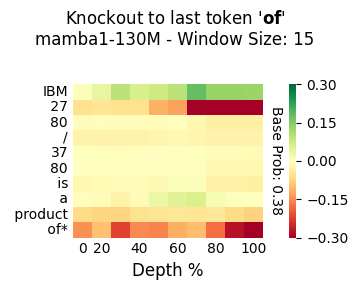

Plotting heatmaps:  20%|██        | 1/5 [00:00<00:01,  2.51it/s]

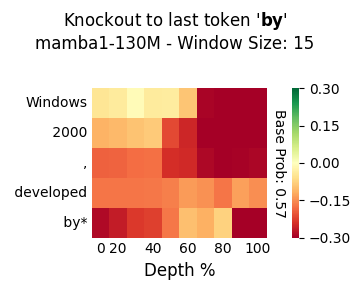

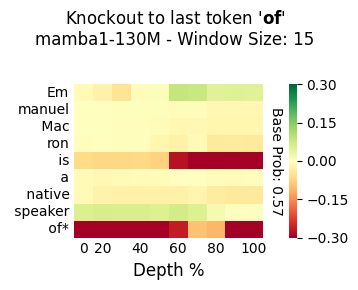

Plotting heatmaps:  60%|██████    | 3/5 [00:00<00:00,  6.95it/s]

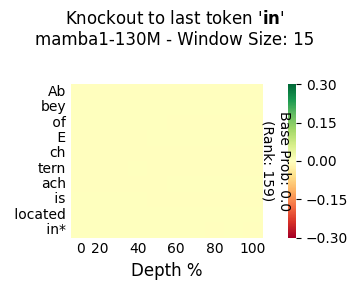

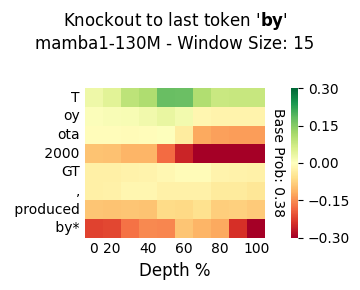

Plotting heatmaps: 100%|██████████| 5/5 [00:00<00:00,  7.63it/s]


In [6]:
# Create Heatmap runner parameters
heatmap_params = HeatmapParams(
    model_arch=MODEL_ARCH,
    model_size=MODEL_SIZE,
    window_size=WINDOW_SIZE,  # 15 for test data, 9 for general use
)

# For heatmaps, use the same specific prompt IDs as the test baseline
heatmap_prompt_filter = SelectivePromptFilteration(
    prompt_ids=tuple(TPromptOriginalIndex(i) for i in ORIGINAL_IDS[SPLIT.TRAIN1])
)
heatmap_input_params = InputParams(
    dataset_name=DatasetName.counter_fact,
    filteration=heatmap_prompt_filter,
)

# Create the runner
heatmap_runner = HeatmapRunner(
    variant_params=heatmap_params, input_params=heatmap_input_params, metadata_params=metadata_params
)

f"🌡️ Created HeatmapRunner: {heatmap_params.model_arch}-{heatmap_params.model_size}, Window: {heatmap_params.window_size}"

# Display heatmap results if available
if heatmap_runner.is_computed():
    f"✅ Heatmap computation complete"
    # Use the runner's built-in plotting method
    heatmap_runner.plot(HEATMAP_PLOT_FUNCS._simple_diff_fixed_0_3, show=True)
    f"🎨 Heatmaps plotted using repository's plotting infrastructure"
else:
    "❌ Heatmap results not computed yet"


## 4. Information Flow Runner
#
The **InfoFlowRunner** performs the core "knockout" analysis, tracing how information flows
from subject tokens to prediction tokens across model layers.

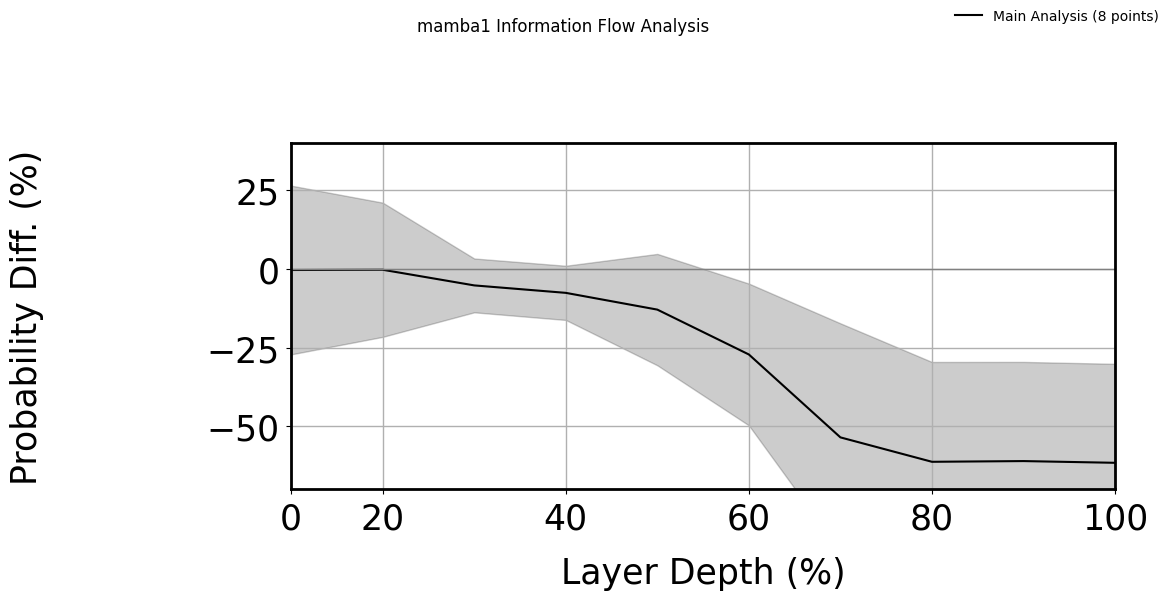

In [7]:
# Create InfoFlow runner parameters
info_flow_params = InfoFlowParams(
    model_arch=MODEL_ARCH,
    model_size=MODEL_SIZE,
    window_size=WINDOW_SIZE,  # 15 for test data, 9 for general use
    source=TokenType.subject,  # Track information from subject tokens
    target=TokenType.last,  # To the last token (where prediction happens)
    feature_category=FeatureCategory.ALL,
)

# Create the runner
info_flow_runner = InfoFlowRunner(
    variant_params=info_flow_params, input_params=input_params, metadata_params=metadata_params
)

f"🌊 Created InfoFlowRunner: {info_flow_params.model_arch}-{info_flow_params.model_size}, {info_flow_params.source}→{info_flow_params.target}"

# Display InfoFlow results if available
if info_flow_runner.is_computed():
    info_flow_outputs = info_flow_runner.get_outputs()
    f"✅ Information flow complete: {len(info_flow_outputs)} windows analyzed"

    # Use repository's plotting infrastructure
    config = InfoFlowPlotConfig(
        title=f"{MODEL_ARCH} Information Flow Analysis",
        metrics_to_show=[TMetricType.DIFF],
        figure_width=12,
        figure_height=6,
    )

    lines = {"Main Analysis": info_flow_outputs}
    fig = create_confidence_plot(lines=lines, confidence_level=0.95, config=config)
    plt.show()

    # Display data structure
    list(info_flow_outputs.keys())[:3]  # Show first few window keys
else:
    "❌ Information flow results not computed yet"


## Summary
#
This notebook demonstrates the complete experimental infrastructure of the SSM Analysis project:
#
### 🏗️ Infrastructure Components:
#
1. **Data Management**: Counter-Fact dataset loading and prompt filteration
2. **Experiment Runners**: Modular, dependency-aware analysis components
3. **Result Banks**: Centralized storage and management of experimental outputs
4. **Parameter Systems**: Flexible configuration for different model architectures
#
### 🔬 Three Core Experiments:
#
1. **EvaluateModel**: Baseline performance measurement
   - Target probabilities, model correctness, prediction rankings
   - Foundation for understanding what the model can predict
#
2. **Heatmap**: Layer-wise impact analysis
   - Visual representation of how different layers affect predictions
   - Identifies which parts of the model are most important
#
3. **InfoFlow**: Information tracing through knockout analysis
   - Tracks how subject information flows to final predictions
   - Reveals where and how factual knowledge emerges
#
### 🧠 Research Insights:
#
- **Layer Specialization**: Different layers show distinct roles in factual processing
- **Information Emergence**: Subject information typically emerges in middle-to-late layers
- **Relation Variability**: Different factual relationships show unique processing patterns
- **Architecture Differences**: The system can compare GPT, Mamba, and other architectures
#
### 🔗 Integration Benefits:
#
- **Comprehensive Analysis**: Multiple perspectives on the same factual processing
- **Cross-Validation**: Results from different experiments confirm findings
- **Scalable Framework**: Easy to add new models, datasets, or analysis types
- **Reproducible Research**: Systematic parameter management and result storage
#
This infrastructure enables deep investigation into how language models process and retrieve
factual information, providing insights that advance our understanding of model internals and
factual reasoning capabilities! 🚀
